# Multi-Seed Sampling for HealthBench Hard Dataset

This notebook creates **multiple random samples** from the HealthBench hard dataset using different random seeds.

## Purpose

- **Statistical validation**: Multiple seeds allow for bootstrap-style confidence intervals
- **Seed hold-out validation**: Test reproducibility across different random samples
- **Variance estimation**: Understand how much results vary due to sample selection

## Configuration

Parameters are configurable at the top of the notebook:
- `NUM_SEEDS`: Number of different random seeds to use
- `SAMPLE_SIZE`: Number of samples per seed
- `STRATEGY`: Sampling strategy
  - `rss` = Random Stratified Sampling (preserves theme distribution)
  - `rs` = Random Sampling (pure random, no stratification)

In [1]:
import json
import random
import hashlib
import urllib.request
from pathlib import Path
from collections import defaultdict, Counter
import tempfile

import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# CONFIGURATION - Modify these parameters as needed
# ============================================================
NUM_SEEDS = 5           # Number of different random seeds
SAMPLE_SIZE = 200       # Samples per seed
STRATEGY = 'rs'        # rss = random stratified sampling, rs = random sampling

# Validate strategy
assert STRATEGY in ('rss', 'rs'), f"Invalid strategy '{STRATEGY}'. Must be 'rss' or 'rs'"

# Strategy descriptions for output
STRATEGY_NAMES = {
    'rss': 'Random Stratified Sampling',
    'rs': 'Random Sampling'
}

# Auto-generated output folder name
OUTPUT_FOLDER = Path(f'../data/data-{NUM_SEEDS}-seeds-{SAMPLE_SIZE}{STRATEGY.upper()}')

# Dataset URL
DATASET_URL = "https://openaipublic.blob.core.windows.net/simple-evals/healthbench/hard_2025-05-08-21-00-10.jsonl"

# Base seeds (will generate NUM_SEEDS consecutive seeds starting from this)
BASE_SEED = 42

# Color palette for themes
THEME_COLORS = {
    'global_health': '#2ecc71',
    'context_seeking': '#3498db',
    'hedging': '#9b59b6',
    'health_data_tasks': '#e74c3c',
    'communication': '#f39c12',
    'complex_responses': '#1abc9c',
    'emergency_referrals': '#e91e63'
}

print(f"Configuration:")
print(f"  - Seeds: {NUM_SEEDS} (starting from {BASE_SEED})")
print(f"  - Sample size: {SAMPLE_SIZE}")
print(f"  - Strategy: {STRATEGY} ({STRATEGY_NAMES[STRATEGY]})")
print(f"  - Output folder: {OUTPUT_FOLDER}")

Configuration:
  - Seeds: 5 (starting from 42)
  - Sample size: 200
  - Strategy: rs (Random Sampling)
  - Output folder: ../data/data-5-seeds-200RS


## 1. Load the Full Dataset

In [2]:
def download_or_load_dataset(url: str) -> list[dict]:
    """Download dataset or load from cache."""
    cache_dir = Path(tempfile.gettempdir()) / "healthbench_cache"
    filename = hashlib.sha256(url.encode()).hexdigest() + ".jsonl"
    cache_path = cache_dir / filename

    if cache_path.exists():
        print(f"Loading from cache: {cache_path}")
        with open(cache_path, 'r') as f:
            return [json.loads(line) for line in f if line.strip()]

    print(f"Downloading dataset from: {url}")
    cache_dir.mkdir(exist_ok=True, parents=True)

    with urllib.request.urlopen(url) as response:
        content = response.read()

    cache_path.write_bytes(content)

    return [json.loads(line) for line in content.decode('utf-8').split('\n') if line.strip()]


def get_theme(example_tags: list[str]) -> str:
    """Extract theme from example_tags."""
    for tag in example_tags:
        if tag.startswith('theme:'):
            return tag.replace('theme:', '')
    return 'unknown'


# Load the dataset
data = download_or_load_dataset(DATASET_URL)
print(f"\nTotal samples in hard dataset: {len(data)}")

Loading from cache: /var/folders/ph/kfdm7zqn361dvr4dxmzjdh680000gp/T/healthbench_cache/df365a255b27e3d06a0eb5de21ce7052579d2f604ee49b29142f103246770835.jsonl

Total samples in hard dataset: 1000


## 2. Original Distribution

In [3]:
# Count themes in full dataset
full_theme_counts = Counter()
for sample in data:
    theme = get_theme(sample.get('example_tags', []))
    full_theme_counts[theme] += 1

# Sort by count (descending)
sorted_themes = sorted(full_theme_counts.items(), key=lambda x: -x[1])
themes = [t[0] for t in sorted_themes]
counts = [t[1] for t in sorted_themes]

print("Full Dataset Theme Distribution:")
print("-" * 50)
for theme, count in sorted_themes:
    pct = count / len(data) * 100
    print(f"  {theme:<20} {count:>4} samples ({pct:5.1f}%)")

Full Dataset Theme Distribution:
--------------------------------------------------
  global_health         280 samples ( 28.0%)
  context_seeking       179 samples ( 17.9%)
  hedging               167 samples ( 16.7%)
  health_data_tasks     115 samples ( 11.5%)
  communication         111 samples ( 11.1%)
  complex_responses      82 samples (  8.2%)
  emergency_referrals    66 samples (  6.6%)


## 3. Sampling Functions

In [4]:
def stratified_sample(data: list[dict], target_total: int, seed: int) -> tuple[list[str], list[dict]]:
    """
    Perform stratified random sampling by theme (RSS strategy).
    
    Returns:
        - list of prompt_ids
        - list of sampling details per theme
    """
    random.seed(seed)

    # Group by theme
    theme_groups = defaultdict(list)
    for sample in data:
        theme = get_theme(sample.get('example_tags', []))
        theme_groups[theme].append(sample['prompt_id'])

    total_samples = len(data)
    selected_ids = []
    sampling_details = []

    # Calculate and sample for each theme
    for theme in sorted(theme_groups.keys()):
        group_ids = theme_groups[theme]
        group_size = len(group_ids)

        # Proportional target (with rounding)
        target_count = round(group_size / total_samples * target_total)

        # Sample
        sampled = random.sample(group_ids, min(target_count, group_size))
        selected_ids.extend(sampled)
        
        sampling_details.append({
            'theme': theme,
            'original': group_size,
            'sampled': len(sampled),
            'original_pct': group_size / total_samples * 100,
            'sampled_pct': len(sampled) / target_total * 100
        })

    # Adjust if we have slightly more or fewer than target due to rounding
    if len(selected_ids) > target_total:
        random.shuffle(selected_ids)
        selected_ids = selected_ids[:target_total]
    elif len(selected_ids) < target_total:
        remaining_ids = [s['prompt_id'] for s in data if s['prompt_id'] not in selected_ids]
        additional = random.sample(remaining_ids, target_total - len(selected_ids))
        selected_ids.extend(additional)

    return selected_ids, sampling_details


def random_sample(data: list[dict], target_total: int, seed: int) -> tuple[list[str], list[dict]]:
    """
    Perform pure random sampling without stratification (RS strategy).
    
    Returns:
        - list of prompt_ids
        - list of sampling details per theme (computed after sampling)
    """
    random.seed(seed)
    
    # Get all prompt_ids and sample randomly
    all_ids = [sample['prompt_id'] for sample in data]
    selected_ids = random.sample(all_ids, target_total)
    
    # Create a lookup for quick access
    id_to_sample = {sample['prompt_id']: sample for sample in data}
    
    # Compute theme distribution of the sample (for analysis)
    total_samples = len(data)
    sampled_theme_counts = Counter()
    for pid in selected_ids:
        theme = get_theme(id_to_sample[pid].get('example_tags', []))
        sampled_theme_counts[theme] += 1
    
    # Get original theme counts
    original_theme_counts = Counter()
    for sample in data:
        theme = get_theme(sample.get('example_tags', []))
        original_theme_counts[theme] += 1
    
    # Build sampling details
    sampling_details = []
    for theme in sorted(original_theme_counts.keys()):
        original = original_theme_counts[theme]
        sampled = sampled_theme_counts.get(theme, 0)
        sampling_details.append({
            'theme': theme,
            'original': original,
            'sampled': sampled,
            'original_pct': original / total_samples * 100,
            'sampled_pct': sampled / target_total * 100
        })
    
    return selected_ids, sampling_details


def sample_data(data: list[dict], target_total: int, seed: int, strategy: str) -> tuple[list[str], list[dict]]:
    """
    Sample data using the specified strategy.
    
    Args:
        data: Full dataset
        target_total: Number of samples to select
        seed: Random seed
        strategy: 'rss' for stratified sampling, 'rs' for random sampling
        
    Returns:
        - list of prompt_ids
        - list of sampling details per theme
    """
    if strategy == 'rss':
        return stratified_sample(data, target_total, seed)
    elif strategy == 'rs':
        return random_sample(data, target_total, seed)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

## 4. Generate Samples for All Seeds

In [5]:
# Create output directory
OUTPUT_FOLDER.mkdir(exist_ok=True, parents=True)

# Generate seeds
seeds = [BASE_SEED + i for i in range(NUM_SEEDS)]

# Store all results
all_samples = {}
all_details = {}

print(f"Generating {NUM_SEEDS} samples of {SAMPLE_SIZE} each using {STRATEGY_NAMES[STRATEGY]}...")
print("=" * 70)

for seed in seeds:
    selected_ids, sampling_details = sample_data(data, SAMPLE_SIZE, seed, STRATEGY)
    all_samples[seed] = selected_ids
    all_details[seed] = sampling_details
    
    print(f"\nSeed {seed}:")
    print(f"  Total samples: {len(selected_ids)}")
    
    # Show theme breakdown
    for d in sorted(sampling_details, key=lambda x: -x['original']):
        print(f"    {d['theme']:<20} {d['sampled']:>3} samples ({d['sampled_pct']:5.1f}%)")

Generating 5 samples of 200 each using Random Sampling...

Seed 42:
  Total samples: 200
    global_health         61 samples ( 30.5%)
    context_seeking       25 samples ( 12.5%)
    hedging               38 samples ( 19.0%)
    health_data_tasks     22 samples ( 11.0%)
    communication         26 samples ( 13.0%)
    complex_responses     18 samples (  9.0%)
    emergency_referrals   10 samples (  5.0%)

Seed 43:
  Total samples: 200
    global_health         52 samples ( 26.0%)
    context_seeking       36 samples ( 18.0%)
    hedging               28 samples ( 14.0%)
    health_data_tasks     25 samples ( 12.5%)
    communication         29 samples ( 14.5%)
    complex_responses     19 samples (  9.5%)
    emergency_referrals   11 samples (  5.5%)

Seed 44:
  Total samples: 200
    global_health         51 samples ( 25.5%)
    context_seeking       32 samples ( 16.0%)
    hedging               37 samples ( 18.5%)
    health_data_tasks     25 samples ( 12.5%)
    communication    

## 5. Analyze Overlap Between Seeds

In [6]:
# Calculate overlap between all pairs of seeds
print("Sample Overlap Analysis")
print("=" * 70)
print(f"\nOverlap matrix (number of shared samples out of {SAMPLE_SIZE}):")
print()

# Header
header = "        " + "  ".join([f"Seed {s}" for s in seeds])
print(header)
print("-" * len(header))

overlap_matrix = []
for seed1 in seeds:
    row = []
    set1 = set(all_samples[seed1])
    row_str = f"Seed {seed1}:"
    for seed2 in seeds:
        set2 = set(all_samples[seed2])
        overlap = len(set1 & set2)
        row.append(overlap)
        row_str += f"  {overlap:>6}"
    overlap_matrix.append(row)
    print(row_str)

# Calculate average overlap (excluding diagonal)
off_diagonal = []
for i, row in enumerate(overlap_matrix):
    for j, val in enumerate(row):
        if i != j:
            off_diagonal.append(val)

print(f"\nAverage overlap between different seeds: {np.mean(off_diagonal):.1f} samples ({np.mean(off_diagonal)/SAMPLE_SIZE*100:.1f}%)")
print(f"Min overlap: {min(off_diagonal)} samples")
print(f"Max overlap: {max(off_diagonal)} samples")

Sample Overlap Analysis

Overlap matrix (number of shared samples out of 200):

        Seed 42  Seed 43  Seed 44  Seed 45  Seed 46
---------------------------------------------------
Seed 42:     200      32      41      40      43
Seed 43:      32     200      37      41      36
Seed 44:      41      37     200      51      41
Seed 45:      40      41      51     200      44
Seed 46:      43      36      41      44     200

Average overlap between different seeds: 40.6 samples (20.3%)
Min overlap: 32 samples
Max overlap: 51 samples


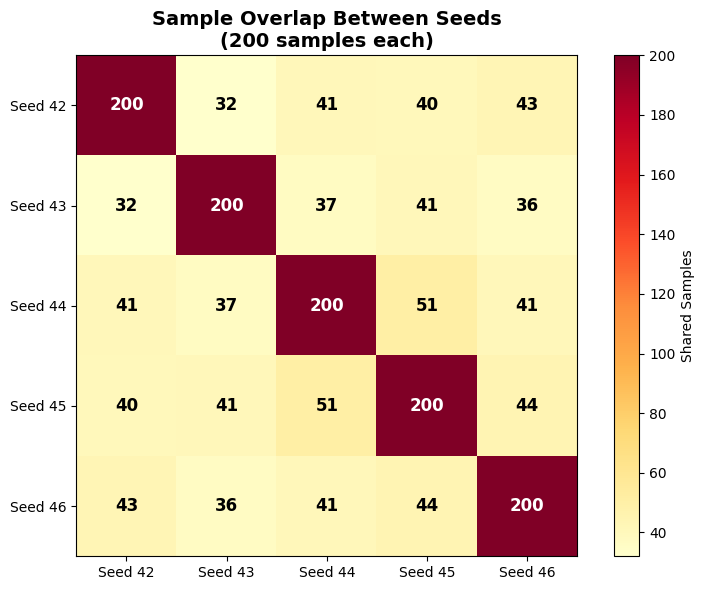

In [7]:
# Visualize overlap as heatmap
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(overlap_matrix, cmap='YlOrRd')

# Labels
ax.set_xticks(range(len(seeds)))
ax.set_yticks(range(len(seeds)))
ax.set_xticklabels([f'Seed {s}' for s in seeds])
ax.set_yticklabels([f'Seed {s}' for s in seeds])

# Add text annotations
for i in range(len(seeds)):
    for j in range(len(seeds)):
        val = overlap_matrix[i][j]
        color = 'white' if val > SAMPLE_SIZE * 0.7 else 'black'
        ax.text(j, i, f'{val}', ha='center', va='center', color=color, fontsize=12, fontweight='bold')

ax.set_title(f'Sample Overlap Between Seeds\n({SAMPLE_SIZE} samples each)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Shared Samples')

plt.tight_layout()
plt.savefig(OUTPUT_FOLDER / 'seed_overlap_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Compare Theme Distributions Across Seeds

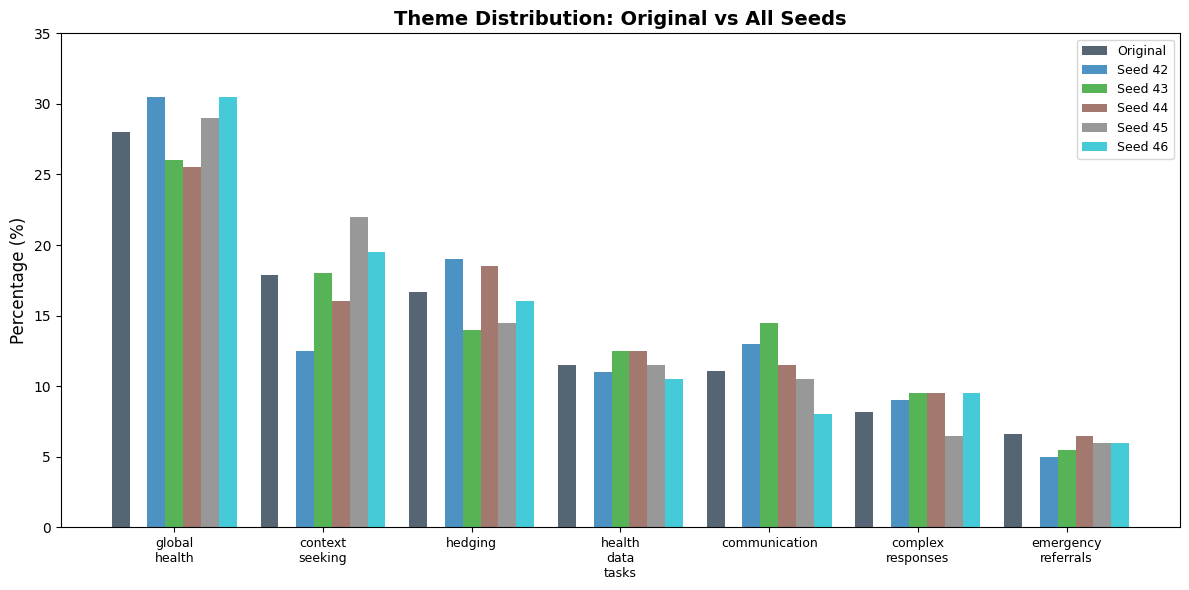

In [8]:
# Collect theme percentages across all seeds
theme_pcts_by_seed = {theme: [] for theme in themes}

for seed in seeds:
    for detail in all_details[seed]:
        theme_pcts_by_seed[detail['theme']].append(detail['sampled_pct'])

# Original percentages
original_pcts = {theme: count / len(data) * 100 for theme, count in full_theme_counts.items()}

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(themes))
width = 0.12

# Plot original
bars_orig = ax.bar(x - width * 3, [original_pcts[t] for t in themes], width, 
                   label='Original', color='#2c3e50', alpha=0.8)

# Plot each seed
colors = plt.cm.tab10(np.linspace(0, 1, NUM_SEEDS))
for i, seed in enumerate(seeds):
    pcts = []
    for theme in themes:
        for detail in all_details[seed]:
            if detail['theme'] == theme:
                pcts.append(detail['sampled_pct'])
                break
    ax.bar(x + width * (i - 1), pcts, width, label=f'Seed {seed}', color=colors[i], alpha=0.8)

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Theme Distribution: Original vs All Seeds', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([t.replace('_', '\n') for t in themes], fontsize=9)
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(0, 35)

plt.tight_layout()
plt.savefig(OUTPUT_FOLDER / 'theme_distribution_all_seeds.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Show variance in theme percentages
print("Theme Distribution Variance Across Seeds")
print("=" * 70)
print(f"{'Theme':<20} {'Original':>10} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-" * 70)

for theme in themes:
    pcts = theme_pcts_by_seed[theme]
    orig = original_pcts[theme]
    print(f"{theme:<20} {orig:>9.1f}% {np.mean(pcts):>9.1f}% {np.std(pcts):>9.2f}% {min(pcts):>9.1f}% {max(pcts):>9.1f}%")

Theme Distribution Variance Across Seeds
Theme                  Original       Mean        Std        Min        Max
----------------------------------------------------------------------
global_health             28.0%      28.3%      2.16%      25.5%      30.5%
context_seeking           17.9%      17.6%      3.22%      12.5%      22.0%
hedging                   16.7%      16.4%      2.03%      14.0%      19.0%
health_data_tasks         11.5%      11.6%      0.80%      10.5%      12.5%
communication             11.1%      11.5%      2.21%       8.0%      14.5%
complex_responses          8.2%       8.8%      1.17%       6.5%       9.5%
emergency_referrals        6.6%       5.8%      0.51%       5.0%       6.5%


## 7. Save All Samples

In [10]:
# Save individual sample files for each seed
saved_files = []

for seed in seeds:
    filename = f'hard_{SAMPLE_SIZE}_sample_seed{seed}.json'
    filepath = OUTPUT_FOLDER / filename
    
    output_data = {
        "description": f"{STRATEGY_NAMES[STRATEGY]} sample of HealthBench hard dataset (seed={seed})",
        "total_samples": len(all_samples[seed]),
        "source": DATASET_URL,
        "random_seed": seed,
        "sample_size": SAMPLE_SIZE,
        "strategy": STRATEGY,
        "strategy_name": STRATEGY_NAMES[STRATEGY],
        "stratification": "theme (7 categories)" if STRATEGY == 'rss' else "none",
        "prompt_ids": sorted(all_samples[seed])
    }
    
    with open(filepath, 'w') as f:
        json.dump(output_data, f, indent=2)
    
    saved_files.append(filepath)
    print(f"Saved: {filepath}")

print(f"\nTotal files saved: {len(saved_files)}")

Saved: ../data/data-5-seeds-200RS/hard_200_sample_seed42.json
Saved: ../data/data-5-seeds-200RS/hard_200_sample_seed43.json
Saved: ../data/data-5-seeds-200RS/hard_200_sample_seed44.json
Saved: ../data/data-5-seeds-200RS/hard_200_sample_seed45.json
Saved: ../data/data-5-seeds-200RS/hard_200_sample_seed46.json

Total files saved: 5


In [11]:
# Save a combined metadata file
metadata = {
    "description": f"Multi-seed {STRATEGY_NAMES[STRATEGY].lower()} metadata for HealthBench hard dataset",
    "num_seeds": NUM_SEEDS,
    "sample_size": SAMPLE_SIZE,
    "strategy": STRATEGY,
    "strategy_name": STRATEGY_NAMES[STRATEGY],
    "base_seed": BASE_SEED,
    "seeds": seeds,
    "source": DATASET_URL,
    "stratification": "theme (7 categories)" if STRATEGY == 'rss' else "none",
    "files": [f.name for f in saved_files],
    "overlap_stats": {
        "average_overlap": float(np.mean(off_diagonal)),
        "average_overlap_pct": float(np.mean(off_diagonal) / SAMPLE_SIZE * 100),
        "min_overlap": int(min(off_diagonal)),
        "max_overlap": int(max(off_diagonal))
    },
    "theme_variance": {
        theme: {
            "original_pct": original_pcts[theme],
            "mean_pct": float(np.mean(theme_pcts_by_seed[theme])),
            "std_pct": float(np.std(theme_pcts_by_seed[theme]))
        }
        for theme in themes
    }
}

metadata_path = OUTPUT_FOLDER / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Saved metadata: {metadata_path}")

Saved metadata: ../data/data-5-seeds-200RS/metadata.json


## Summary

### What we created:

In [12]:
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(f"\nOutput folder: {OUTPUT_FOLDER}")
print(f"\nGenerated files:")
for f in sorted(OUTPUT_FOLDER.glob('*.json')):
    print(f"  - {f.name}")
for f in sorted(OUTPUT_FOLDER.glob('*.png')):
    print(f"  - {f.name}")

print(f"\nConfiguration:")
print(f"  - Number of seeds: {NUM_SEEDS}")
print(f"  - Sample size per seed: {SAMPLE_SIZE}")
print(f"  - Strategy: {STRATEGY} ({STRATEGY_NAMES[STRATEGY]})")
print(f"  - Seeds used: {seeds}")

print(f"\nUsage example:")
print(f"  # Run evaluation on seed 42")
print(f"  python -m simple-evals.simple_evals --model=gpt-4o-mini --eval=healthbench_hard \\")
print(f"      --sample-file={OUTPUT_FOLDER}/hard_{SAMPLE_SIZE}_sample_seed42.json --n-threads=10")


SUMMARY

Output folder: ../data/data-5-seeds-200RS

Generated files:
  - hard_200_sample_seed42.json
  - hard_200_sample_seed43.json
  - hard_200_sample_seed44.json
  - hard_200_sample_seed45.json
  - hard_200_sample_seed46.json
  - metadata.json
  - seed_overlap_heatmap.png
  - theme_distribution_all_seeds.png

Configuration:
  - Number of seeds: 5
  - Sample size per seed: 200
  - Strategy: rs (Random Sampling)
  - Seeds used: [42, 43, 44, 45, 46]

Usage example:
  # Run evaluation on seed 42
  python -m simple-evals.simple_evals --model=gpt-4o-mini --eval=healthbench_hard \
      --sample-file=../data/data-5-seeds-200RS/hard_200_sample_seed42.json --n-threads=10
